# Evolutionary Algorithms for Neural Network Optimization

In this assignment, we will explore the application of **Evolutionary Algorithms (EAs)** to optimize the weights of a neural network for solving the **Lunar Lander problem**. The Lunar Lander environment, provided by OpenAI Gym, simulates the challenge of controlling a lunar module to land it safely on a designated landing pad. The task involves applying thrust and rotation to navigate the lander under the influence of gravity while avoiding crashes or drifting out of bounds.

The goal is to train a neural network that acts as a controller for the lander. By optimizing the network weights, the controller learns how to achieve smooth and successful landings. Instead of traditional gradient-based optimization methods, we will use evolutionary algorithms, as introduced in class, to explore the weight space.

In this context, evolutionary algorithms offer a robust and gradient-free optimization approach that is particularly useful for tasks with non-differentiable objectives or high-dimensional search spaces. You will program an EA to optimize the network weights and compare its performance against a **Random Search** baseline, where weights are sampled randomly and evaluated.

The problem at hand is to design an EA that finds a set of neural network weights maximizing the total reward in the Lunar Lander environment. Rewards are given for successful landings and penalized for crashes or inefficient maneuvers. By comparing the EA with Random Search, you will analyze the effectiveness and efficiency of evolutionary optimization methods.


# Student: Eliana Ferreira

# Assignment Task (MUST READ)

In this assignment, you will use Evolutionary Algorithms (EAs) to optimize the weights of a neural network for the Lunar Lander environment from OpenAI Gym. You will compare the performance of your implementation with a **Random Search** baseline provided in the starter code.

## 0. Setup
Some modules are required to run the code:
```python
python -m pip install gymnasium torch swi
python -m pip install "gymnasium[box2d]"
```

## 1. Analyze the provided implementation
- Review the given **Random Search** code. Understand how it generates and evaluates random weight sets for the neural network. Run the code to familiarize yourself with its output and performance.

## 2. Implement the following:
- **2.1 Choose one Evolutionary Algorithm** covered in class, such as Genetic Algorithms, Differential Evolution, or Evolutionary Strategies.
- **2.2 Implement the selected Evolutionary Algorithm** in Python. Make sure to:
  - Represent the weights of the neural network as the individuals in the population.
  - Design a fitness function based on the reward obtained in the Lunar Lander environment.
  - Include key algorithm mechanisms (e.g., selection, crossover, mutation).

## 3. Run experiments and compare:
Conduct experiments with both the **Random Search** and your EA implementation. For each experiment, run **5 different random seeds** to account for variability. Analyze the following setup:
- **3.1 Your EA implementation vs. Random Search.**

### Metrics to compare:
- **3.3 Best reward achieved**: Compare the highest rewards obtained by each setup.
- **3.4 Convergence speed**: Measure the number of generations required to reach a reward threshold (e.g., a landing reward of 200 or higher).
- **3.5 Consistency**: Report the average and standard deviation of the results across the random seeds.

## 4. Analyze the results:
Report the findings of your experiments in a structured format. Your analysis should include:
- **4.1 Best reward achieved for each setup** (include plots of reward vs. generation for each method).
- **4.2 Average and standard deviation of rewards across runs.**
- **4.3 Convergence speed (generations to reach the threshold) across different setups.**
- **4.4 Observations on the performance improvements (if any) from the enhancements you implemented.**

## 5. Report the best-performing setup:
Summarize the best setup you found for optimizing the Lunar Lander environment, justifying your choice based on your experimental results.

---

### Note:
- As in previous assignments, ensure you run the same setup multiple times with different random seeds to draw reliable conclusions.
- Use the theoretical slides and material discussed in class to support your analysis.

### Further Reading:
- [OpenAI Gym Documentation](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
- Additional material shared in class.

---

Would you like me to provide any specific sample code, such as the Random Search baseline or a basic template for the EA?

In [1]:
import numpy as np
print(np.__version__)

1.26.4


In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import sys
import random

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.Tanh(),
            nn.Linear(4, output_dim),
        )
    def forward(self, x):
        output = self.model(x)
        return torch.argmax(output).item()
    

Dada a arquitetura da rede neural definida em cima cada vetor-solução será constituído por 56 parâmetros. Porque sabemos que de input temos 8 variáveis, de output temos 4 possíveis ações e depois temos uma camada escondida com 4 neurónios, assim o número de pesos a otimizar são:<br>
 - Pesos <br>
    -- Camada 1 = 8x4 = 32<br>
    -- Camada 2 = 4x4 = 16
 - Biases <br>
    -- Camada 1 = 4 <br>
    -- Camada 2 = 4 <br>

    - Nº Total de parâmetros a otimizar = 32 + 16 + 4 + 4 = 56 parâmetros

In [4]:

class LunarLanderAgent:
    def __init__(self, env_name='LunarLander-v3', search_algorithm=None, episodes=1, time_steps=1000):
        torch.manual_seed(2000)
        np.random.seed(2000)
        random.seed(2000)
        self.env = gym.make("LunarLander-v3", continuous=False, enable_wind=False)
        self.episodes = episodes
        self.time_steps = time_steps
        self.search_algorithm = search_algorithm
        self.input_dim = self.env.observation_space.shape[0]
        self.output_dim = self.env.action_space.n  # Discrete action space
        self.mlp = self.create_mlp(self.input_dim, self.output_dim)
    
    def create_mlp(self, input_dim, output_dim):
        """
        Creates an MLP using PyTorch.
        """
        mlp = MLP(input_dim, output_dim)
        return mlp
    
    def get_param_vector(self):
        params = []
        for param in self.mlp.parameters():
            params.append(param.data.cpu().numpy().flatten())
        return np.concatenate(params)
    
    def set_param_vector(self, vector):
        offset = 0
        for param in self.mlp.parameters():
            shape = param.shape
            size = np.prod(shape)
            param.data = torch.tensor(vector[offset:offset + size].reshape(shape), dtype=torch.float32)
            offset += size
    
    def evaluate(self, vector):
        self.set_param_vector(vector)
        total_reward = 0
        for _ in range(self.episodes):
            obs = self.env.reset(seed=42)
            episode_reward = 0
            terminated = False
            obs = obs[0]
            i = 0
            while not terminated and i < self.time_steps:
                obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
                action = self.mlp(obs)
                #print(action)
                obs, reward, terminated, done, info = self.env.step(action)
                episode_reward += reward
                i += 1
            total_reward += episode_reward
        #print(total_reward)
        return total_reward / self.episodes

    def train(self):
        if self.search_algorithm:
            self.best_params = self.search_algorithm(self)
            self.save_agent("best_agent_cma_es.pkl")
        else:
            raise ValueError("No search algorithm provided")
        
    def test(self):

        
        seed_value = 2000  #pus uma seed aqui 
        np.random.seed(seed_value)
        random.seed(seed_value)
        torch.manual_seed(seed_value)
        
        
        env = gym.make('LunarLander-v3', render_mode="human")
        obs = env.reset()
        total_reward = 0
        terminated = False
        obs = obs[0]
        i = 0
        while not terminated and i < self.time_steps:
            env.render()
            obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = self.mlp(obs)
            obs, reward, terminated, done, info = env.step(action)
            total_reward += reward
            i += 1
        print(f"Test Reward: {total_reward}")
        env.close()
        


    def save_agent(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.get_param_vector(), f)

    def load_agent(self, filename):
        with open(filename, 'rb') as f:
            param_vector = pickle.load(f)
        self.set_param_vector(param_vector)


In [5]:
def make_evolution_plot(best, mean, title, save=False):
    plt.plot(best, label='Best Reward')
    plt.plot(mean, label='Mean Reward')
    plt.xlabel('Generation')
    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.draw()
    if save:
        plt.savefig(f'{title}.png')
    plt.pause(0.01)
    plt.clf()


In [6]:
def random_search(agent, population_size=200, generations=50, alpha=0.01, sigma=0.1):
    seeds = [2000, 2025, 2026, 2027, 2028]  
    results = []  
    all_best_rewards = []  
    all_mean_rewards = []  

    overall_best_reward_random = -np.inf  
    overall_best_params = None  

    for seed in seeds:
       
        np.random.seed(seed)

        param_vector = agent.get_param_vector()
        num_params = len(param_vector)
        best_params = param_vector
        best_reward = -np.inf
        best_rewards = []
        mean_rewards = []

        for generation in range(generations):
            population = []
            for i in range(population_size):
                ind = param_vector + sigma * np.random.randn(num_params)
                population.append(ind)
            rewards = []
            for individual in population:
                r = agent.evaluate(individual)
                rewards.append(r)
            rewards = np.array(rewards)
            max_reward_idx = np.argmax(rewards)
            if rewards[max_reward_idx] > best_reward:
                best_reward = rewards[max_reward_idx]
                best_params = population[max_reward_idx]
                agent.set_param_vector(best_params)
                agent.save_agent(f'best_agent_random_search_seed_{seed}.pkl')

            
            print(f"Seed {seed}, Generation {generation + 1}: Best Reward = {rewards.max()}, Mean Reward = {rewards.mean()}")

            best_rewards.append(rewards.max())
            mean_rewards.append(rewards.mean())

        all_best_rewards.append(best_rewards)
        all_mean_rewards.append(mean_rewards)
        results.append((seed, best_rewards, mean_rewards))

       
        if best_reward > overall_best_reward_random:
            overall_best_reward_random = best_reward
            overall_best_params = best_params

        
        make_evolution_plot(best_rewards, mean_rewards, f"RS (Seed {seed})", True)

   
    avg_best_rewards_per_gen = np.mean(all_best_rewards, axis=0)
    avg_mean_rewards_per_gen = np.mean(all_mean_rewards, axis=0)

    
    std_reward_per_gen_random = np.std([avg_best_rewards_per_gen, avg_mean_rewards_per_gen], axis=0)

    
    if overall_best_params is not None:
        agent.set_param_vector(overall_best_params)
        agent.save_agent("best_agent_random_search_overall.pkl")
        print(f"Overall best agent saved with reward: {overall_best_reward_random}")
        print(f"Average Best Reward per Generation: {avg_best_rewards_per_gen}")
        print(f"Average Mean Reward per Generation: {avg_mean_rewards_per_gen}")
        print(f"Standard Deviation between Average Best and Mean Reward per Generation: {std_reward_per_gen_random}")
        print(f"Overall Best Reward: {overall_best_reward_random}")

    
    make_evolution_plot(avg_best_rewards_per_gen, avg_mean_rewards_per_gen, "RS Average All Seeds", True)


    return (
        results,
        avg_best_rewards_per_gen,
        avg_mean_rewards_per_gen,
        std_reward_per_gen_random,
        overall_best_reward_random,
        overall_best_params,
    )



# 2. Choose and Implement an EA

## Algorithm Chosen: CMA-ES (Covariance Matrix Adaptation Evolution Strategy)

### Justificação da escolha do CMA-ES

O LunarLander é um problema contínuo, uma vez que apresenta ações contínuas, como a força dos propulsores; o seu estado é descrito por várias variáveis contínuas com a posição ou a velocidade da nave e ainda a função de fitness é também contínua sendo calculada por vários parâmetros que podem acrescentar ou retirar pontos à reward final. 
Assim o algoritmo CMA-ES pareceu uma escolha adequada uma vez que é uma estratégia evolutiva projetada especificamente para problemas contínuos.
No CMA-ES cada indíviduo é representado por um vetor de parâmetros (números reais) o que se alinha perfeitamente com o espaço de ações contínuas do LunarLander que descrevi anteriormente, onde os parâmetros a serem otimizados são valores reais.



### Representação

No CMA-ES, cada indivíduo ou solução é representado com um vetor de números reais. No contexto do LunarLander, esse vetor representa os parâmetros a otimizar, neste caso, os pesos de uma rede neural. O número de dimensões corresponde ao número de parâmetros que cada solução tem de otimizar. 

### Função de Fitness

A função de fitness (agent.evaluate(ind)) avalia o desempenho de um indivíduo (vetor de parâmetros) no ambiente LunarLander. Devolve uma recompensa que reflete o quão bem a nave pousa, determinada por uma série de regras próprias do problema. Quanto maior a recompensa, melhor a solução. O objetivo do CMA-ES é maximizar essa recompensa.

### Seleção

- O CMA-ES seleciona os melhores indivíduos (aqueles com as maiores recompensas) para gerar a próxima geração. No código, os melhores 25% dos indivíduos (top_25_percent - mu/4) são selecionados para atualizar a média e a matriz de covariância. <br>
- E ainda foi implemetado um mecanismo de elitismo para ter a certeza que a melhor solução nunca se perderia - incluimos sempre o melhor indivíduo da geração anterior na geração seguinte. 

### Operadores de Variação

O CMA-ES gera novos indivíduos (offspring) amostrando de uma distribuição normal multivariada, cuja média e matriz de covariância são atualizadas a cada geração. Isso permite que o algoritmo explore o espaço de busca de forma eficiente, adaptando-se à forma da função de fitness.
No CMA-ES os conceitos tradicionais de crossover e mutação, como são conhecidos em outros algoritmos evolutivos (por exemplo, algoritmos genéticos), não são aplicados diretamente. Em vez disso, o CMA-ES usa mecanismos diferentes, mas equivalentes em espírito, para gerar diversidade e explorar o espaço de busca.<br>

"Crossover": <br>

a) Atualização da Média (μ):<br>
 - A média da distribuição normal multivariada é atualizada como a média dos melhores indivíduos (por exemplo, os top 25%).<br>

 - Isso equivale a uma forma de "crossover implícito", pois a nova média combina informações de múltiplos indivíduos (os melhores da geração atual)<br>

b) Matriz de Covariância (Σ):<br>
 - A matriz de covariância captura as correlações entre as dimensões dos melhores indivíduos.<br>

 - Isso permite que o algoritmo "herde" informações sobre a estrutura do espaço de busca a partir dos melhores indivíduos, de forma semelhante ao crossover.

 "Mutação": <br>

a) Amostragem da Distribuição Normal Multivariada:<br>

 - Novos indivíduos são gerados amostrando de uma distribuição normal multivariada, que introduz variações aleatórias em todas as dimensões.

 - A matriz de covariância controla a magnitude e a direção dessas variações, o que equivale a uma forma de "mutação adaptativa".

b) Tamanho do Passo (σ):<br>
O tamanho do passo (σ) controla o escalamento da matriz de covariância, determinando o quão grandes são as variações introduzidas.Se σ for grande, as mutações serão maiores, permitindo uma exploração mais ampla do espaço de busca. Se σ for pequeno, as mutações serão menores, permitindo uma exploitation mais refinada.

c) Adaptação da Matriz de Covariância:<br>
 - A matriz de covariância é adaptada iterativamente com base no desempenho dos melhores indivíduos.<br>

 - Isso permite que o algoritmo ajuste automaticamente a direção e a magnitude das mutações para explorar regiões mais promissoras do espaço de busca.

In [7]:

def cma_es(agent, dimensions, mu=200, generations=50, bounds=(-5, 5)):
    seeds = [2000, 2025, 2026, 2027, 2028] 

    results = []  
    all_best_rewards = []  
    all_mean_rewards = []  

    overall_best_reward = float('-inf')  
    best_agent_params = None  

    for seed in seeds:

        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)

        top_25_percent = max(1, mu // 4)  
        mean = np.zeros(dimensions) 
        sigma = 1.2 
        cov = np.eye(dimensions)  

        best_rewards = []  
        mean_rewards = []  

        
        best_individual = None
        best_individual_reward = float('-inf') 

        for generation in range(generations):
            
            offspring = np.random.multivariate_normal(mean, sigma**2 * cov, size=mu)
            offspring = np.clip(offspring, bounds[0], bounds[1])  

            
            rewards = np.array([agent.evaluate(ind) for ind in offspring])

            
            max_reward_idx = np.argmax(rewards)
            if rewards[max_reward_idx] > best_individual_reward:
                best_individual_reward = rewards[max_reward_idx]
                best_individual = offspring[max_reward_idx]

           # implementei um elitismo unitário para não perder o melhor
            offspring[0] = best_individual
            rewards[0] = best_individual_reward

            
            best_indices = np.argsort(rewards)[-top_25_percent:]
            top_offspring = offspring[best_indices]
            top_rewards = rewards[best_indices]

           
            mean = np.mean(top_offspring, axis=0)
            cov = np.cov(top_offspring.T) + 1e-8 * np.eye(dimensions)  

            
            max_reward = rewards.max()
            best_rewards.append(max_reward)  
            mean_rewards.append(rewards.mean())  
            print(f"Seed {seed}, Generation {generation + 1}: Best Reward = {max_reward}, Mean Reward = {rewards.mean()}")

            
            if max_reward > overall_best_reward:
                overall_best_reward = max_reward
                best_agent_params = offspring[np.argmax(rewards)]  
                agent.save_agent("best_agent_cma_es.pkl")
                
        
        results.append((seed, best_rewards, mean_rewards)) 
        all_best_rewards.append(best_rewards)  
        all_mean_rewards.append(mean_rewards)  

       
        make_evolution_plot(best_rewards, mean_rewards, f"CMA-ES (Seed {seed})", True)

   
    avg_best_rewards_per_gen = np.mean(all_best_rewards, axis=0)  
    avg_mean_rewards_per_gen = np.mean(all_mean_rewards, axis=0)  
    
    std_reward_per_gen = np.std([avg_best_rewards_per_gen, avg_mean_rewards_per_gen], axis=0)

    make_evolution_plot(avg_best_rewards_per_gen, avg_mean_rewards_per_gen, f"CMA-ES Average All Seeds", True)

    print(f"Average Best Reward per Generation: {avg_best_rewards_per_gen}")
    print(f"Average Mean Reward per Generation: {avg_mean_rewards_per_gen}")
    print(f"Standard Deviation between Average Best and Mean Reward per Generation: {std_reward_per_gen}")
    print(f"Overall Best Reward: {overall_best_reward}")


    print("Saved parameters:", agent.get_param_vector())
    agent.set_param_vector(best_agent_params)
    agent.save_agent("best_agent_cma_es.pkl2")
    print("Best agent parameters and reward saved to 'best_agent_cma_es.pkl2'.")


    return results, avg_best_rewards_per_gen, avg_mean_rewards_per_gen, std_reward_per_gen

## Train !

Seed 2000, Generation 1: Best Reward = -36.32465292143202, Mean Reward = -567.9277313619369
Seed 2000, Generation 2: Best Reward = -36.32465292143202, Mean Reward = -367.9596087109062
Seed 2000, Generation 3: Best Reward = 14.303303007173696, Mean Reward = -268.8038460560827
Seed 2000, Generation 4: Best Reward = 187.4816070138344, Mean Reward = -241.76959488463433
Seed 2000, Generation 5: Best Reward = 206.167635154411, Mean Reward = -250.500169892192
Seed 2000, Generation 6: Best Reward = 206.167635154411, Mean Reward = -217.14025474257645
Seed 2000, Generation 7: Best Reward = 206.167635154411, Mean Reward = -195.28992564796548
Seed 2000, Generation 8: Best Reward = 206.167635154411, Mean Reward = -187.25557046813307
Seed 2000, Generation 9: Best Reward = 206.81214481305258, Mean Reward = -172.9396036630917
Seed 2000, Generation 10: Best Reward = 206.81214481305258, Mean Reward = -165.4403914948775
Seed 2000, Generation 11: Best Reward = 206.81214481305258, Mean Reward = -157.434111

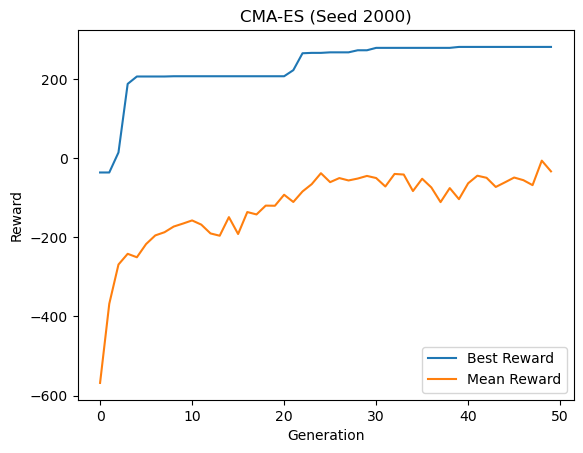

Seed 2025, Generation 1: Best Reward = -75.2333103280329, Mean Reward = -602.1499492750288
Seed 2025, Generation 2: Best Reward = 5.377630434800892, Mean Reward = -371.19607263643263
Seed 2025, Generation 3: Best Reward = 125.1016579347616, Mean Reward = -245.30938793054338
Seed 2025, Generation 4: Best Reward = 125.1016579347616, Mean Reward = -262.2396159121253
Seed 2025, Generation 5: Best Reward = 125.1016579347616, Mean Reward = -200.94502280694377
Seed 2025, Generation 6: Best Reward = 153.11784876193798, Mean Reward = -198.99069971474142
Seed 2025, Generation 7: Best Reward = 153.11784876193798, Mean Reward = -170.58749799987604
Seed 2025, Generation 8: Best Reward = 192.8192767449249, Mean Reward = -163.25993504329904
Seed 2025, Generation 9: Best Reward = 192.8192767449249, Mean Reward = -167.2505579256944
Seed 2025, Generation 10: Best Reward = 195.15489758628004, Mean Reward = -127.27374915874958
Seed 2025, Generation 11: Best Reward = 195.15489758628004, Mean Reward = -158.

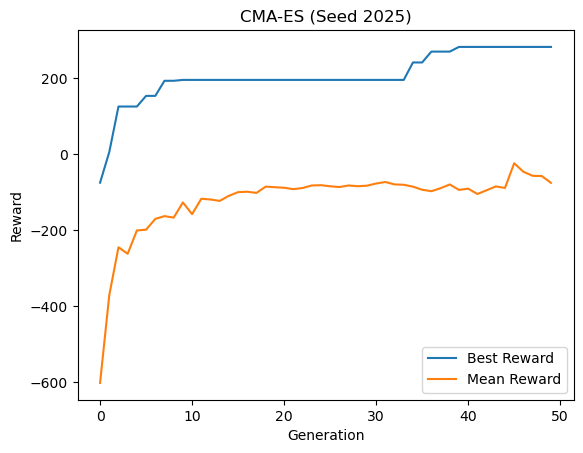

Seed 2026, Generation 1: Best Reward = -78.78574427231538, Mean Reward = -565.219055729441
Seed 2026, Generation 2: Best Reward = 6.45450930953271, Mean Reward = -395.08950988014857
Seed 2026, Generation 3: Best Reward = 6.45450930953271, Mean Reward = -311.6411502831328
Seed 2026, Generation 4: Best Reward = 6.45450930953271, Mean Reward = -244.8547843806521
Seed 2026, Generation 5: Best Reward = 6.45450930953271, Mean Reward = -226.79454883052836
Seed 2026, Generation 6: Best Reward = 194.4929786462718, Mean Reward = -221.16623637692012
Seed 2026, Generation 7: Best Reward = 194.4929786462718, Mean Reward = -184.34619219899582
Seed 2026, Generation 8: Best Reward = 194.4929786462718, Mean Reward = -144.04236081242715
Seed 2026, Generation 9: Best Reward = 194.4929786462718, Mean Reward = -138.1194360475571
Seed 2026, Generation 10: Best Reward = 194.4929786462718, Mean Reward = -144.78063179346643
Seed 2026, Generation 11: Best Reward = 194.4929786462718, Mean Reward = -106.977001082

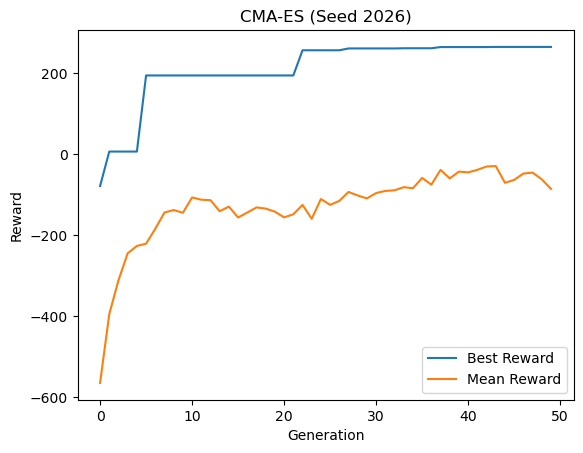

Seed 2027, Generation 1: Best Reward = -12.208653588083948, Mean Reward = -529.1206274750908
Seed 2027, Generation 2: Best Reward = 4.94756594765451, Mean Reward = -367.37735450940244
Seed 2027, Generation 3: Best Reward = 4.94756594765451, Mean Reward = -283.4384999083102
Seed 2027, Generation 4: Best Reward = 4.94756594765451, Mean Reward = -273.89302202863115
Seed 2027, Generation 5: Best Reward = 4.94756594765451, Mean Reward = -238.2225371627493
Seed 2027, Generation 6: Best Reward = 4.9583754956095305, Mean Reward = -215.9321504702926
Seed 2027, Generation 7: Best Reward = 4.9583754956095305, Mean Reward = -252.0696336705418
Seed 2027, Generation 8: Best Reward = 193.2250601984227, Mean Reward = -217.47150696703818
Seed 2027, Generation 9: Best Reward = 193.2250601984227, Mean Reward = -231.70354865271423
Seed 2027, Generation 10: Best Reward = 194.54358268227864, Mean Reward = -190.68328910908645
Seed 2027, Generation 11: Best Reward = 194.54358268227864, Mean Reward = -249.7216

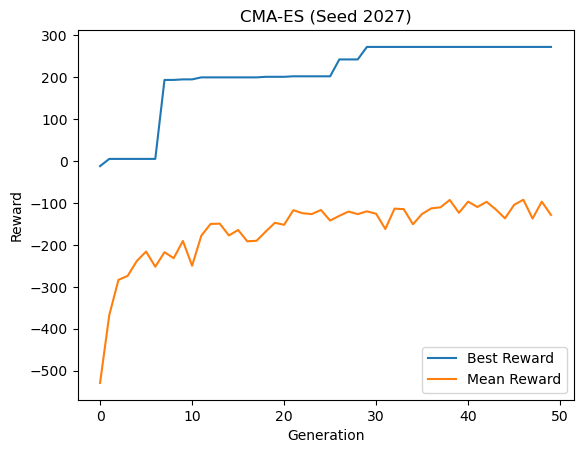

Seed 2028, Generation 1: Best Reward = -66.54836159602401, Mean Reward = -569.8024970846448
Seed 2028, Generation 2: Best Reward = -5.94487315535855, Mean Reward = -470.80831208090024
Seed 2028, Generation 3: Best Reward = 143.71029929897497, Mean Reward = -301.8751445561568
Seed 2028, Generation 4: Best Reward = 143.71029929897497, Mean Reward = -211.8646288528507
Seed 2028, Generation 5: Best Reward = 143.71029929897497, Mean Reward = -223.6002740636025
Seed 2028, Generation 6: Best Reward = 143.71029929897497, Mean Reward = -205.6307011967977
Seed 2028, Generation 7: Best Reward = 143.71029929897497, Mean Reward = -210.57528784690237
Seed 2028, Generation 8: Best Reward = 143.71029929897497, Mean Reward = -210.83676758461905
Seed 2028, Generation 9: Best Reward = 143.71029929897497, Mean Reward = -200.07482923924846
Seed 2028, Generation 10: Best Reward = 143.71029929897497, Mean Reward = -149.44169461235794
Seed 2028, Generation 11: Best Reward = 143.71029929897497, Mean Reward = -

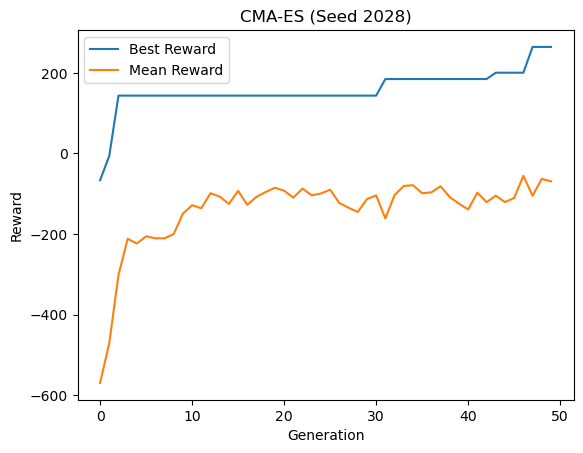

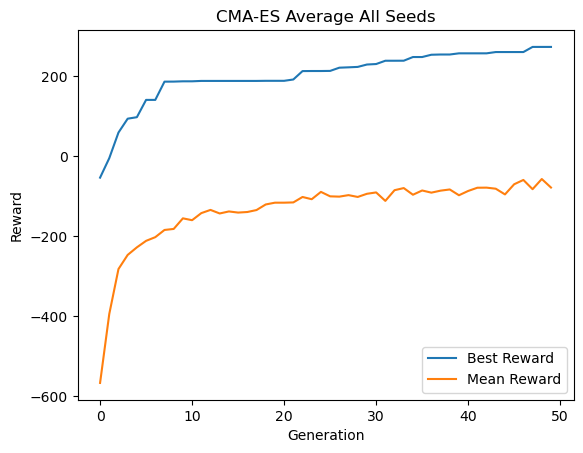

Average Best Reward per Generation: [-53.82014454  -5.09796408  58.9034671   93.5391279   97.27633353
 140.48942747 140.48942747 186.08305001 186.21195194 186.94278061
 186.94278061 187.89821128 187.89821128 187.89821128 187.89821128
 187.89821128 187.89821128 187.89821128 188.17158973 188.17158973
 188.17158973 191.48796345 212.47238869 212.66423028 212.66423028
 212.93290078 220.97359736 221.87838233 222.92551973 228.89182603
 230.10813316 238.34462664 238.34462664 238.43792184 247.61577174
 247.61577174 253.33296447 253.92017301 253.92017301 256.85768051
 256.85768051 256.85768051 256.85768051 260.06623704 260.06623704
 260.06623704 260.06623704 272.87899725 272.87899725 272.87899725]
Average Mean Reward per Generation: [-566.84397219 -394.48617156 -282.21360575 -246.92432921 -228.01251055
 -211.7720085  -202.57370747 -184.57322818 -182.01759511 -155.52395123
 -160.15419278 -142.47935206 -134.45491322 -143.35267889 -138.28317463
 -141.13402138 -139.7061848  -134.80171538 -120.846332

<Figure size 640x480 with 0 Axes>

In [ ]:
# Evolve and Train!
np.random.seed(46)
torch.random.manual_seed(46)
agent = LunarLanderAgent(search_algorithm=cma_es, episodes=3, time_steps=1000)
agent.train()



## Test ! 

In [20]:
# Test!
agent = LunarLanderAgent(search_algorithm=cma_es, episodes=3, time_steps=1000)
agent.load_agent(f'best_agent_cma_es.pkl') 
#print("Loaded parameters:", loaded_agent.get_param_vector())
agent.test()


Test Reward: -312.79879728147375


Seed 2000, Generation 1: Best Reward = -200.35604215354513, Mean Reward = -734.5768003201933
Seed 2000, Generation 2: Best Reward = -200.35604215354513, Mean Reward = -764.9266664142021
Seed 2000, Generation 3: Best Reward = -260.38718865572287, Mean Reward = -748.3882675165648
Seed 2000, Generation 4: Best Reward = -207.77179758785405, Mean Reward = -749.2206054631695
Seed 2000, Generation 5: Best Reward = -195.15671882282174, Mean Reward = -756.3684914589888
Seed 2000, Generation 6: Best Reward = -114.70465869786928, Mean Reward = -740.8644874344873
Seed 2000, Generation 7: Best Reward = -260.38718865572287, Mean Reward = -761.6451184337221
Seed 2000, Generation 8: Best Reward = -207.77179758785405, Mean Reward = -755.3523477760582
Seed 2000, Generation 9: Best Reward = -280.4285420420294, Mean Reward = -758.701414314659
Seed 2000, Generation 10: Best Reward = -260.38718865572287, Mean Reward = -762.3984927883904
Seed 2000, Generation 11: Best Reward = -244.9745624281445, Mean Reward

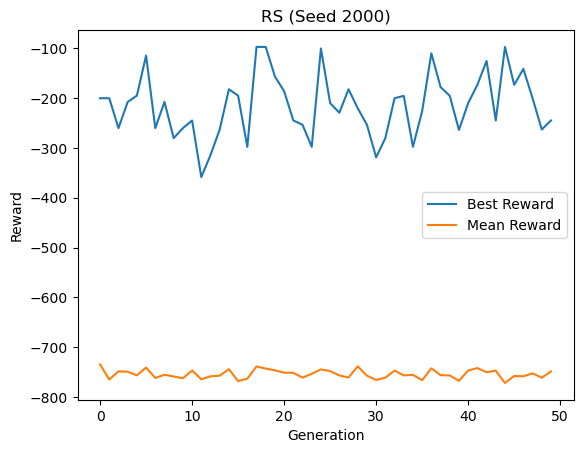

Seed 2025, Generation 1: Best Reward = -30.60013720208603, Mean Reward = -658.8551194002698
Seed 2025, Generation 2: Best Reward = -97.38672267252802, Mean Reward = -667.8284871797913
Seed 2025, Generation 3: Best Reward = -100.40471189812506, Mean Reward = -674.980010643408
Seed 2025, Generation 4: Best Reward = -30.60013720208603, Mean Reward = -685.6068136025066
Seed 2025, Generation 5: Best Reward = -97.38672267252802, Mean Reward = -684.9871664214143
Seed 2025, Generation 6: Best Reward = -30.60013720208603, Mean Reward = -670.0766887370047
Seed 2025, Generation 7: Best Reward = -97.38672267252802, Mean Reward = -672.0014339243113
Seed 2025, Generation 8: Best Reward = -30.60013720208603, Mean Reward = -673.1901268857099
Seed 2025, Generation 9: Best Reward = -97.38672267252802, Mean Reward = -653.3850994608097
Seed 2025, Generation 10: Best Reward = -125.61532125498024, Mean Reward = -673.9500877023615
Seed 2025, Generation 11: Best Reward = -100.40471189812506, Mean Reward = -68

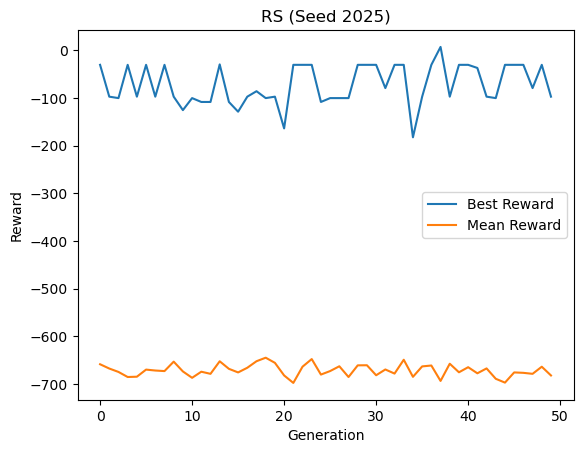

Seed 2026, Generation 1: Best Reward = -116.13751840524945, Mean Reward = -638.4704885298321
Seed 2026, Generation 2: Best Reward = -30.60013720208603, Mean Reward = -612.2574523548269
Seed 2026, Generation 3: Best Reward = -100.40471189812506, Mean Reward = -625.6684149809973
Seed 2026, Generation 4: Best Reward = -100.40471189812506, Mean Reward = -622.8428334942333
Seed 2026, Generation 5: Best Reward = -30.60013720208603, Mean Reward = -632.8639718083589
Seed 2026, Generation 6: Best Reward = -30.60013720208603, Mean Reward = -622.0185970491807
Seed 2026, Generation 7: Best Reward = -20.769665697055245, Mean Reward = -626.88246936599
Seed 2026, Generation 8: Best Reward = -30.60013720208603, Mean Reward = -639.3249949967301
Seed 2026, Generation 9: Best Reward = -160.02167832073087, Mean Reward = -630.6913486528197
Seed 2026, Generation 10: Best Reward = -100.40471189812506, Mean Reward = -637.6403991260531
Seed 2026, Generation 11: Best Reward = -97.38672267252802, Mean Reward = -

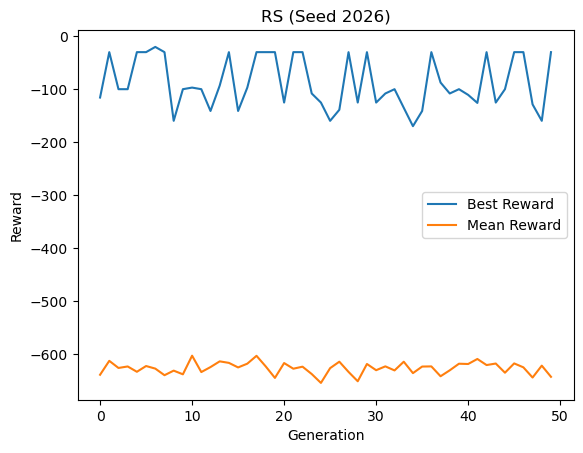

Seed 2027, Generation 1: Best Reward = -117.33993380617879, Mean Reward = -697.3212040361421
Seed 2027, Generation 2: Best Reward = -210.18299450504517, Mean Reward = -699.148318399892
Seed 2027, Generation 3: Best Reward = -108.50283207243724, Mean Reward = -717.6561398246427
Seed 2027, Generation 4: Best Reward = -139.20433582736806, Mean Reward = -706.2387052152902
Seed 2027, Generation 5: Best Reward = -164.9441145773684, Mean Reward = -703.8528354321854
Seed 2027, Generation 6: Best Reward = -163.7348128617732, Mean Reward = -697.242780122603
Seed 2027, Generation 7: Best Reward = -88.29037872461947, Mean Reward = -693.9456726817554
Seed 2027, Generation 8: Best Reward = -30.60013720208603, Mean Reward = -692.3840976750979
Seed 2027, Generation 9: Best Reward = -191.14055729668084, Mean Reward = -710.0623607690804
Seed 2027, Generation 10: Best Reward = -182.43174074236188, Mean Reward = -704.7257873640588
Seed 2027, Generation 11: Best Reward = -150.00072230608876, Mean Reward = 

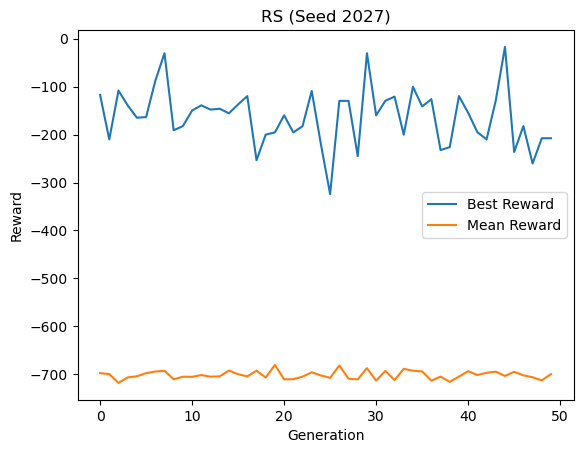

Seed 2028, Generation 1: Best Reward = -98.01380460163413, Mean Reward = -718.3268298456221
Seed 2028, Generation 2: Best Reward = -101.56153151178232, Mean Reward = -715.9101391964018
Seed 2028, Generation 3: Best Reward = -294.3020819086893, Mean Reward = -727.8846762183167
Seed 2028, Generation 4: Best Reward = -108.50283207243724, Mean Reward = -719.539162170963
Seed 2028, Generation 5: Best Reward = -373.87041075929955, Mean Reward = -725.8484116097181
Seed 2028, Generation 6: Best Reward = -125.05640075746618, Mean Reward = -730.9117211360883
Seed 2028, Generation 7: Best Reward = -475.6526316436023, Mean Reward = -726.21149965035
Seed 2028, Generation 8: Best Reward = -443.6255576224073, Mean Reward = -722.9043727977656
Seed 2028, Generation 9: Best Reward = -217.79921211635508, Mean Reward = -721.5934413674803
Seed 2028, Generation 10: Best Reward = -439.4543718584343, Mean Reward = -727.3274972621139
Seed 2028, Generation 11: Best Reward = -517.2791668228615, Mean Reward = -72

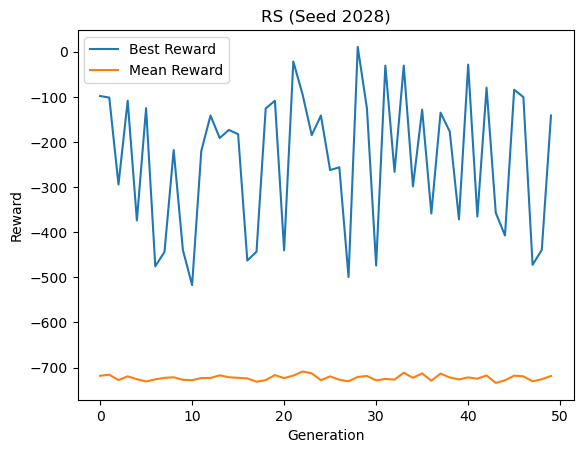

Overall best agent saved with reward: 10.78569685103406
Average Best Reward per Generation: [-112.48948723 -128.01748561 -172.80030529 -117.29676292 -172.39162081
  -92.93922934 -188.49731748 -148.63955336 -189.35534249 -221.65866688
 -222.00917723 -185.28980159 -170.77388653 -144.78097595 -130.11357977
 -157.09705389 -215.10236481 -182.15589036 -110.85092615 -117.75451903
 -215.21279331 -104.6900998  -118.29242281 -146.22037232 -139.27481522
 -211.45323863 -171.00014922 -188.53380377 -122.15792028  -94.20235497
 -221.83383556 -125.73347213 -143.72145329 -118.50383334 -209.91206476
 -146.9608264  -131.28955695 -125.23917978 -160.92814639 -177.29003207
 -107.05062272 -179.47252728 -108.64984844 -191.42333684 -130.6242399
 -111.03860627  -97.09785288 -228.31535602 -220.16628439 -144.40820441]
Average Mean Reward per Generation: [-689.51008843 -692.01421271 -698.91550184 -696.68962399 -700.78417535
 -692.2228549  -696.13723881 -696.63118803 -694.88673291 -701.20845285
 -693.91979611 -699.

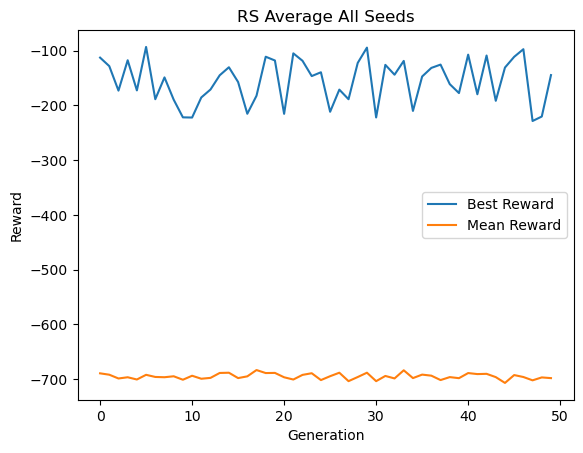

<Figure size 640x480 with 0 Axes>

In [107]:
# Evolve and Train!
np.random.seed(46)
torch.random.manual_seed(46)
agent = LunarLanderAgent(search_algorithm=random_search, episodes=3, time_steps=1000)
agent.train()

In [76]:
# Test!
agent = LunarLanderAgent(search_algorithm=random_search, episodes=3, time_steps=1000)
agent.load_agent("best_agent_random_search_overall.pkl") 
#print("Loaded parameters:", loaded_agent.get_param_vector())
agent.test()


Test Reward: -545.1339957708919


# 4. Random Vs. CMA_ES 

## Curvas de Otimização - Média de todas as seeds

### Curva de otimização CMA-ES &nbsp;&nbsp;&nbsp;VS&nbsp;&nbsp;&nbsp;Curva de otimização Random Search                                                                      

                                      

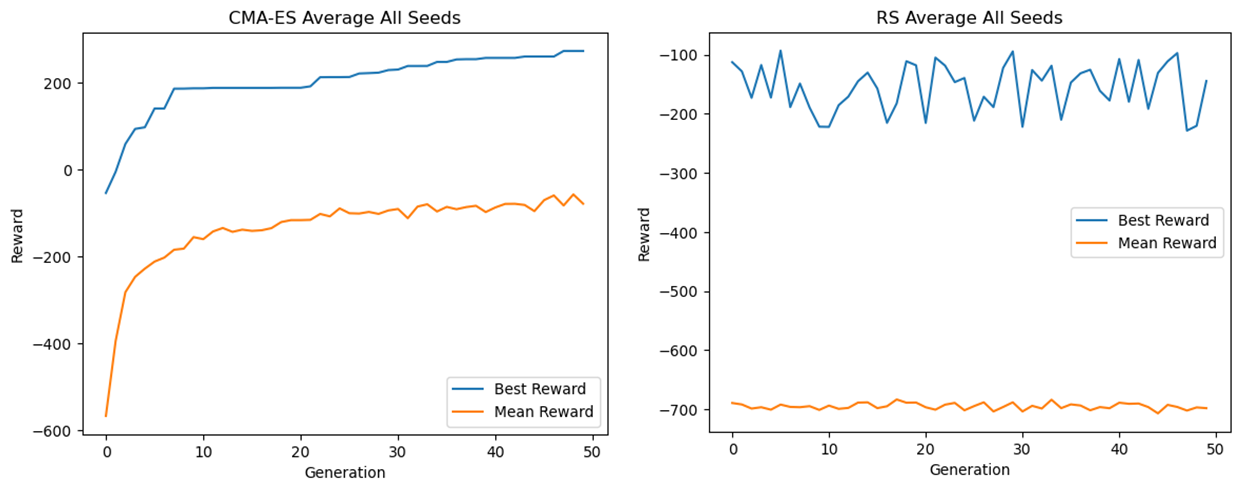

Através das curvas de otimização dos dois algoritmos referentes à média de todas as seeds corridos, é muito evidente a grande discrepência entre os dois métodos. Concluindo que o Random Search realmente não obteve resultados nada satisfatórios, o que já era expectável, uma vez que tende a ser ineficiente para resolver problemas complexos como o LunarLander porque não possui uma estratégia de busca otimizada, explorando aleatoriamente o espaço de soluções sem um critério de refinamento. 

## Médias e Desvios 

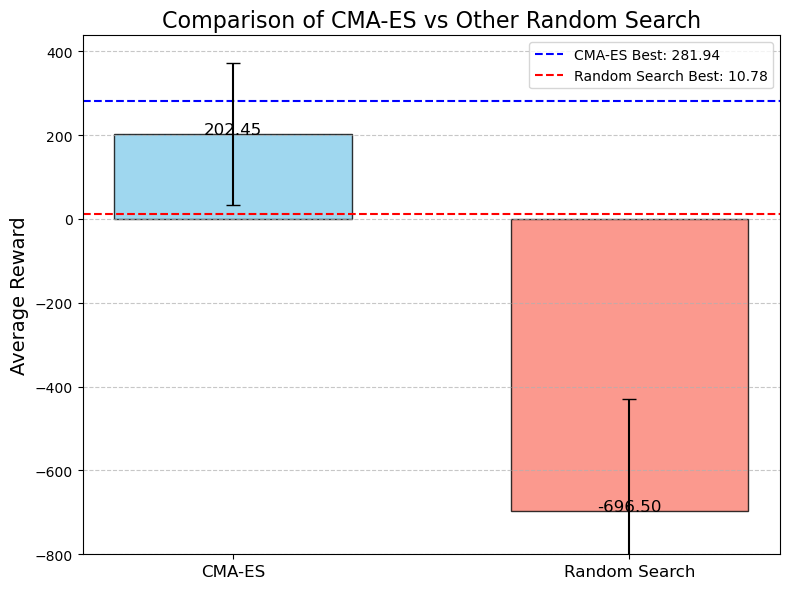

In [110]:
cma_es_mean = 202.45 
cma_es_std = 168.56   
rs_mean = -696.50  
rs_std = 267.96   


cma_es_best = 281.94  
rs_best = 10.78

labels = ['CMA-ES', 'Random Search']
means = [cma_es_mean, rs_mean]
std_devs = [cma_es_std, rs_std]

x = np.arange(len(labels)) 
width = 0.6  

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(x, means, width, alpha=0.8, color=['skyblue', 'salmon'], edgecolor='black')


ax.axhline(cma_es_best, color='blue', linestyle='--', label=f'CMA-ES Best: {cma_es_best}')
ax.axhline(rs_best, color='red', linestyle='--', label=f'Random Search Best: {rs_best}')

for i, bar in enumerate(bars):
    mean = means[i]
    std = std_devs[i]
    ax.errorbar(bar.get_x() + bar.get_width() / 2, mean, yerr=std, fmt='none', color='black', capsize=5)

ax.set_ylabel('Average Reward', fontsize=14)
ax.set_title('Comparison of CMA-ES vs Other Random Search', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)


for bar, mean in zip(bars, means):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{mean:.2f}', ha='center', fontsize=12)


ax.legend()


ax.set_ylim(bottom=-800)


plt.tight_layout()
plt.show()





A figura acima visa mostrar a média dos resultados de todas as seeds assim como o desvio padrão entre o melhor valor médio e o valor médio de todas as seeds para os dois cenários.

# Conclusão

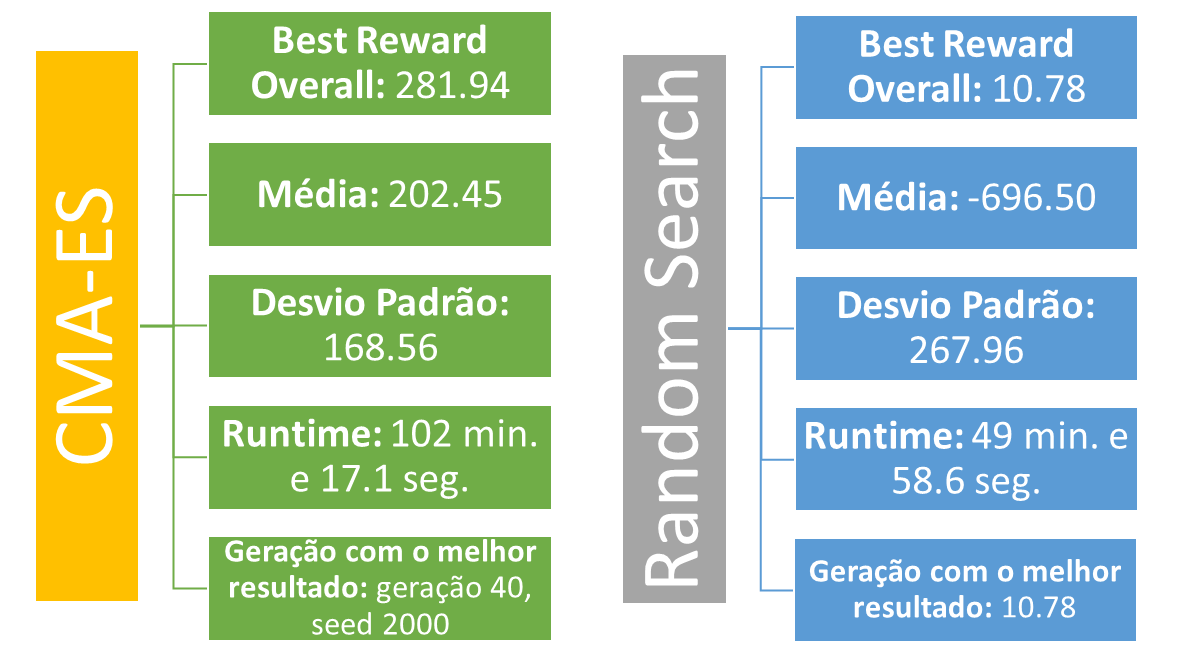

Os esquemas acima descrevem todos os resultados apurados para os dois algoritmos.<br> 

Conclui-se assim que o problema LunarLander pode ser resolvido com sucesso através de uma rede neural (de apenas uma camada escondida com 4 neurónios fully conected) otimizada pelo algoritmo CMA-ES. 